# Project 5 - Part B (Continues after Part A)
### Image Warping and Mosaicing
Romil Bhardwaj

In [1]:
import csv
import math
import cv2
import numpy as np
import pandas as pd
import skimage
import skimage.io as skio
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy.linalg import LinAlgError
from scipy.spatial.qhull import Delaunay
from skimage.draw import draw
from skimage.transform import rescale, resize, downscale_local_mean
import os
import glob
import random

# Part A
### Methods to read images and annotated kyepoints

In [2]:
def read_keypoints(csv_path):
    with open(csv_path, 'r') as f:
        return np.array([list(map(float,rec)) for rec in csv.reader(f, delimiter=',')])

def read_img_and_keypoints(img_path, target_res=None, csv_suffix=""):
    img = skio.imread(img_path)

    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    csv_path = os.path.join(os.path.dirname(img_path), f'{img_filename}{csv_suffix}.csv')

    keypoints = read_keypoints(csv_path)
    if target_res:
        target_x, target_y = target_res
        current_x, current_y, _ = img.shape
        x_rescale = target_x/current_x
        y_rescale = target_y/current_y
        # Resize image:
        img = resize(img, (target_y, target_x), anti_aliasing=True)
        # Resize keypoints:
        keypoints[:,0] *= x_rescale
        keypoints[:,1] *= y_rescale
    return img, keypoints

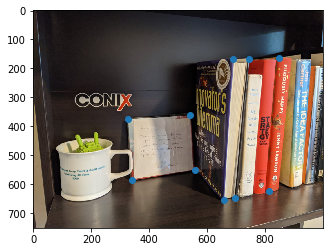

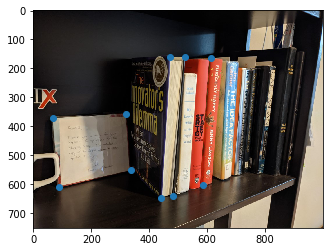

In [3]:
# Test iamge reading and keypoints
img1, kps1 = read_img_and_keypoints('imgs/shelf1.jpg')

plt.imshow(img1)
plt.scatter(x=kps1[:,0], y=kps1[:,1])
plt.savefig('outputs/annotated_eg1.jpg', bbox_inches='tight')

plt.figure()
img2, kps2 = read_img_and_keypoints('imgs/shelf2.jpg')
plt.imshow(img2)
plt.scatter(x=kps2[:,0], y=kps2[:,1])
plt.savefig('outputs/annotated_eg2.jpg', bbox_inches='tight')

## Compute homography


In [4]:
def get_coeff_row(p1, p2):
    return np.array([[-p2[0], -p2[1], -1, 0, 0, 0, p2[0]*p1[0], p2[1]*p1[0]],
                    [0, 0, 0, -p2[0], -p2[1], -1, p2[0]*p1[1], p2[1]*p1[1]]])
    return top

def compute_homography(pts1, pts2):
    assert pts1.shape[0] == pts2.shape[0]
    num_pts = pts1.shape[0]
    out_mat = np.expand_dims(-1*pts1.flatten(), axis=1)
    coeff_rows = []
    for i in range(0, num_pts):
        coeff_rows.append(get_coeff_row(pts1[i, :], pts2[i, :]))
    coeff_mat = np.vstack(coeff_rows)

    H_arr = (np.linalg.lstsq(coeff_mat, out_mat)[0]).T[0]
    H = np.array([[H_arr[0], H_arr[1], H_arr[2]],
                  [H_arr[3], H_arr[4], H_arr[5]],
                   [H_arr[6], H_arr[7], 1.]])
    return H

## Warping functions

In [5]:
def get_canvas_dim(im1_shape, im2_shape, H):
    trf_max_x, trf_max_y, trf_min_x, trf_min_y = get_bbox(im2_shape, H)
    max_x = max(trf_max_x, im1_shape[1], im2_shape[1])
    max_y = max(trf_max_y, im1_shape[0], im2_shape[0])
    return max_x, max_y, trf_min_x, trf_min_y

def get_bbox(target_shape, H):
    y_max, x_max = target_shape[0], target_shape[1]

    edges = [np.array([[0], [y_max], [1]]),
             np.array([[x_max], [y_max], [1]]),
             np.array([[0], [0], [1]]),
             np.array([[x_max], [0], [1]])]
    new_edges = []
    for point in edges:
        transformed_pt = np.matmul(H, point)
        transformed_pt = transformed_pt/transformed_pt[-1]
        new_edges.append(transformed_pt)
    new_edges = np.array(new_edges, dtype=np.int).squeeze()
    new_edges = np.delete(new_edges, 2, 1)  # Remove 1s

    trf_max_x, trf_max_y = np.max(new_edges, axis=0)
    trf_min_x, trf_min_y = np.min(new_edges, axis=0)

    return trf_max_x, trf_max_y, trf_min_x, trf_min_y

def get_mask_shape(im1_shape, im2_shape, H):
    max_x, max_y, min_x, min_y = get_canvas_dim(im1_shape, im2_shape, H)
    colmask, rowmask = draw.polygon([0, max_x + abs(min_x), max_x + abs(min_x), 0],
                        [0, 0, max_y + abs(min_y), max_y + abs(min_y)])
    return colmask, rowmask

def get_mask(im1_shape, im2_shape, H):
    colmask, rowmask = get_mask_shape(im1_shape, im2_shape, H)
    mask_mult = np.array(np.vstack([colmask, rowmask, np.ones(len(colmask))]))
    mask_trf = np.matmul(np.linalg.inv(H), mask_mult)
    colmask_trf, rowmask_trf, z_trf = np.squeeze(mask_trf[0]), np.squeeze(mask_trf[1]), np.squeeze(mask_trf[2])
    colmask_trf = (colmask_trf / z_trf).astype(np.int)
    rowmask_trf = (rowmask_trf / z_trf).astype(np.int)
    return colmask_trf, rowmask_trf, mask_mult

def get_canvas(im1_shape, im2_shape, H):
    max_x, max_y, min_x, min_y = get_canvas_dim(im1_shape, im2_shape, H)
    return np.zeros((max_y + abs(min_y) + 1, max_x + abs(min_x) + 1, 3)).astype(np.int)

def get_target_idxs(valid_indices, mask, im2_shape, H):
    max_x, max_y, min_x, min_y = get_bbox(im2_shape, H)
    offset_x = abs(min(min_x, 0))
    offset_y = abs(min(min_y, 0))
    targets_x = np.squeeze(np.asarray(mask[0], dtype=np.int))[valid_indices]
    targets_y = np.squeeze(np.asarray(mask[1], dtype=np.int))[valid_indices]
    targets_x += offset_x
    targets_y += offset_y

    return offset_x, offset_y, targets_x, targets_y

def get_alpha_mask(im1_shape):
    img_half = int(im1_shape[1]/2)
    # Alpha: Ones for the first half, linearly fall to 0 after first half
    alpha = np.hstack([np.ones(img_half), np.linspace(1, 0, img_half)])
    # Replicate for each horz row
    alpha = np.vstack([alpha]*im1_shape[0])
    alpha = alpha.reshape((alpha.shape[0], alpha.shape[1], 1))
    return alpha

def blend(canvas, im, alpha_mask, offset_x, offset_y):
    x_lim = im.shape[1] + offset_x
    y_lim = im.shape[0] + offset_y
    canvas[offset_y:y_lim, offset_x:x_lim] = im * alpha_mask + canvas[offset_y:y_lim, offset_x:x_lim] * (1 - alpha_mask)
    return canvas

def mosaic(im1, im2, H, do_blend=True):
    colmask, rowmask, mask = get_mask(im1.shape, im2.shape, H)
    canvas = get_canvas(im1.shape, im2.shape, H)

    # Set masks to valid indices
    valid_indices = np.where((colmask >= 0) & (colmask < im2.shape[1]) & (rowmask >= 0) & (rowmask < im2.shape[0]))
    colmask_valid = colmask[valid_indices]
    rowmask_valid = rowmask[valid_indices]

    # Get target pixels
    offset_x, offset_y, target_x, target_y = get_target_idxs(valid_indices, mask, im2.shape, H)

    # Write image pixels to canvas
    canvas[target_y, target_x] = im2[rowmask_valid, colmask_valid]

    if do_blend:    # Set to false for rectification
        # Blend with linear alpha mask
        alpha_mask = get_alpha_mask(im1.shape)
        canvas = blend(canvas, im1, alpha_mask, offset_x, offset_y)
    return canvas

## Mosaic example

/mnt/d/wsl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app
/mnt/d/wsl/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/mnt/d/wsl/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: outputs/out_mosaic.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


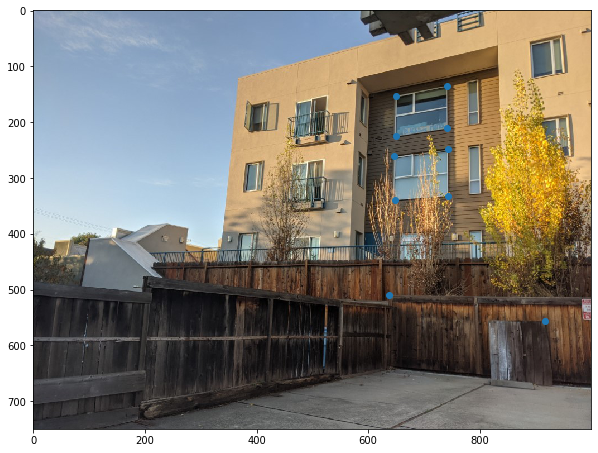

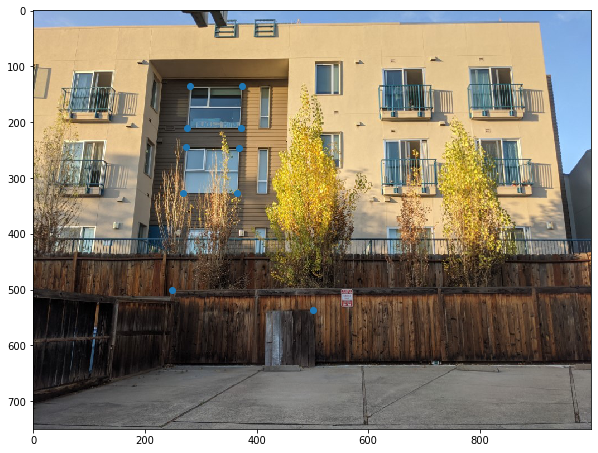

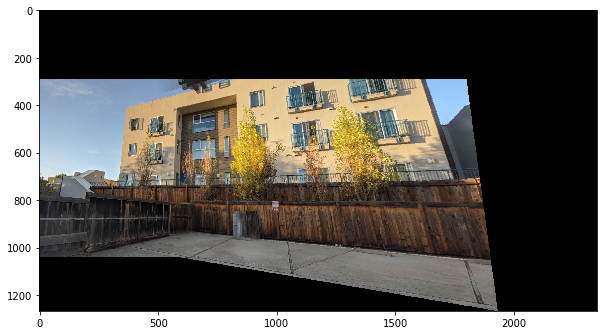

In [17]:
img_name = "out"
img1, kps1 = read_img_and_keypoints(f'imgs/{img_name}1.jpg')
plt.figure(figsize=[10,10])
plt.imshow(img1)
plt.scatter(x=kps1[:,0], y=kps1[:,1])
plt.savefig(f'outputs/annotated_{img_name}1.jpg', bbox_inches='tight')

img2, kps2 = read_img_and_keypoints(f'imgs/{img_name}2.jpg')
plt.figure(figsize=[10,10])
plt.imshow(img2)
plt.scatter(x=kps2[:,0], y=kps2[:,1])
plt.savefig(f'outputs/annotated_{img_name}2.jpg', bbox_inches='tight')

H = compute_homography(kps1, kps2)
mos = mosaic(img1, img2, H)
plt.figure(figsize=[10,10])
plt.imshow(mos)
skio.imsave(f'outputs/{img_name}_mosaic.jpg', mos)

## Rectification example

<ipython-input-5-7b2dc8722018>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H_arr = (np.linalg.lstsq(coeff_mat, out_mat)[0]).T[0]
<ipython-input-40-6995e98b0604>:14: UserWarning: outputs/shelf_rectified.jpg is a low contrast image
  skio.imsave(f'outputs/{img_name}_rectified.jpg', res)
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


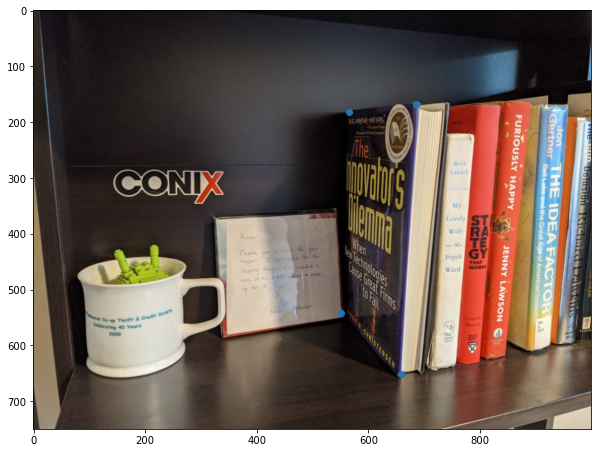

In [40]:
# Read image
img_name = "shelf"
img, kps = read_img_and_keypoints(f'imgs/{img_name}1.jpg', csv_suffix="_rectify")
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.scatter(x=kps[:,0], y=kps[:,1])
plt.savefig(f'outputs/{img_name}_rectificationpts.jpg', bbox_inches='tight')

target_kps = [[0,0], [400,0], [0,400], [400,400]]
target_kps = np.array(target_kps, dtype=np.int)
H = compute_homography(target_kps, kps)

res = mosaic(np.zeros([400,400,3]),img, H, do_blend=False)
skio.imsave(f'outputs/{img_name}_rectified.jpg', res)

# Part B



### Detecting corner features

## Corner detection and ANMS

In [6]:
from harris import get_harris_corners
from skimage.color import rgb2gray

def get_area_points(point, radius):
    x, y = np.mgrid[point[0]-radius:point[0]+radius+1,
                    point[1]-radius:point[1]+radius+1]
    return np.vstack([x.flatten(), y.flatten()]).T

def check_maximal_neigh(h_map, point, radius):
    area = h_map[point[0]-radius:point[0]+radius+1,
                 point[1]-radius:point[1]+radius+1]

    if area.size == 0:
        return [point], point

    max_val = np.max(area)
    max_point = point + np.array(np.where(area == max_val)).flatten() - radius
    to_eliminate = get_area_points(point, radius)
    return [to_eliminate, max_point]

def anms(h_image, points, goal_num):
    radius = 10
    points_buf = points.copy()
    new_batch = []

    print("Goal: ", goal_num, " Start: ", len(points_buf))
    while len(points_buf) > goal_num:
        while len(points_buf) > 0:
            to_elim, max_point = check_maximal_neigh(h_image, points_buf[0], radius)
            new_batch.append(max_point)
            points_buf_idx = (points_buf[:, None] == to_elim).all(-1).any(-1)
            points_buf_idx = np.invert(points_buf_idx)
            points_buf = points_buf[points_buf_idx]
        print("New size: ", len(new_batch))
        radius += 5
        points_buf = np.array(new_batch.copy())
        new_batch = []

    return points_buf

def get_patches(image, points):
    patches = []
    for point in points:
        if point[1] - 20 < 0 or point[1] + 20 > image.shape[1] or point[0] - 20 < 0 or point[0] + 20 > image.shape[0]:
            continue
        patch = image[point[0]-20:point[0]+20, point[1]-20:point[1]+20]
        patches.append((point, patch))
    return patches

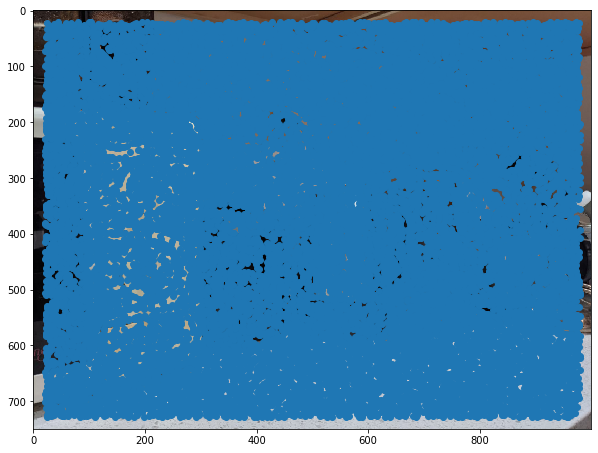

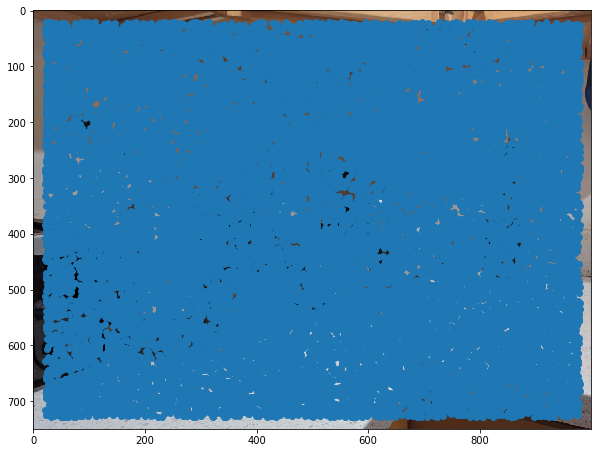

In [76]:
EDGE_DISCARD = 20

img_name = "kit"
img1, manual_kps1 = read_img_and_keypoints(f'imgs/{img_name}1.jpg')
img_gray1 = rgb2gray(img1)
h1, harris_coords1 = get_harris_corners(img_gray1, EDGE_DISCARD)

plt.figure(figsize=[10,10])
plt.imshow(img1)
plt.scatter(x=harris_coords1[1,:], y=harris_coords1[0,:])
#plt.savefig(f'outputs/{img_name}_harris1.jpg', bbox_inches='tight')

img2, manual_kps2 = read_img_and_keypoints(f'imgs/{img_name}2.jpg')
img_gray2 = rgb2gray(img2)
h2, harris_coords2 = get_harris_corners(img_gray2, EDGE_DISCARD)

plt.figure(figsize=[10,10])
plt.imshow(img2)
plt.scatter(x=harris_coords2[1,:], y=harris_coords2[0,:])
#plt.savefig(f'outputs/{img_name}_harris2.jpg', bbox_inches='tight')

In [77]:
# Do ANMS
anms_pts2 = anms(h2, harris_coords2.T, 500)
anms_pts1 = anms(h1, harris_coords1.T, 500)

Goal:  500  Start:  17516
New size:  3311
New size:  1055
New size:  531
New size:  332
Goal:  500  Start:  17360
New size:  3294
New size:  1038
New size:  521
New size:  318


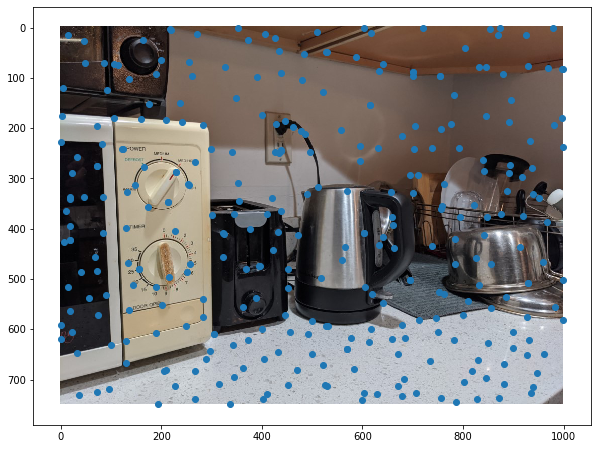

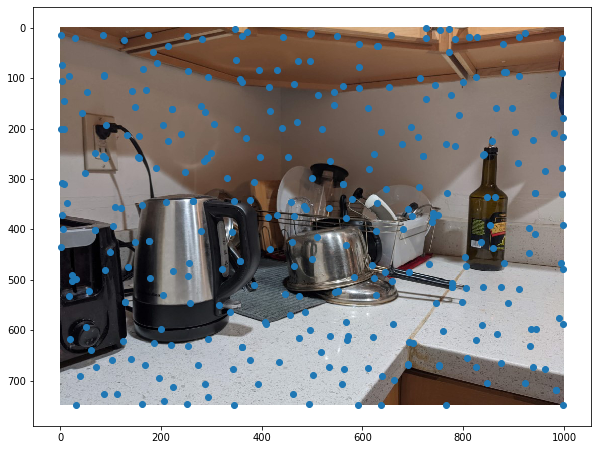

In [78]:
plt.figure(figsize=[10,10])
plt.imshow(img1)
plt.scatter(x=anms_pts1[:,1], y=anms_pts1[:,0])

plt.figure(figsize=[10,10])
plt.imshow(img2)
plt.scatter(x=anms_pts2[:,1], y=anms_pts2[:,0])

In [79]:
# Get patches and create mapping
patches1 = get_patches(img_gray1, anms_pts1)
patches2 = get_patches(img_gray2, anms_pts2)
feature_patches1 = get_feature_patches(patches1)
feature_patches2 = get_feature_patches(patches2)
feat_map = compute_map_features(feature_patches1, feature_patches2)
feat_map = conv_featmap(feat_map)

In [80]:
def conv_featmap(feat_map):
    new_feat_map = {}
    for coords1, coords2  in feat_map.items():
        new_feat_map[tuple([coords1[1], coords1[0]])] = np.array([coords2[1],coords2[0]])
    return new_feat_map

16


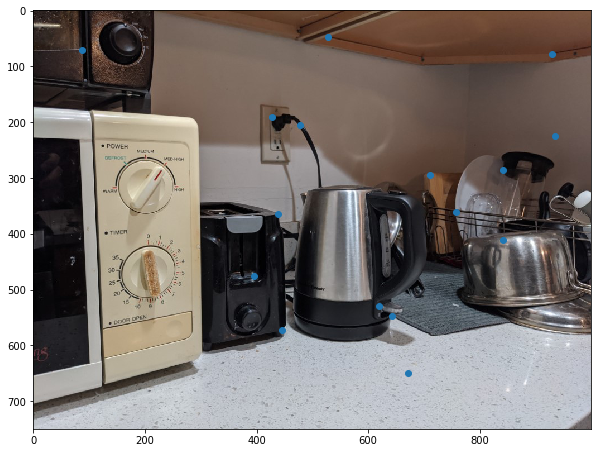

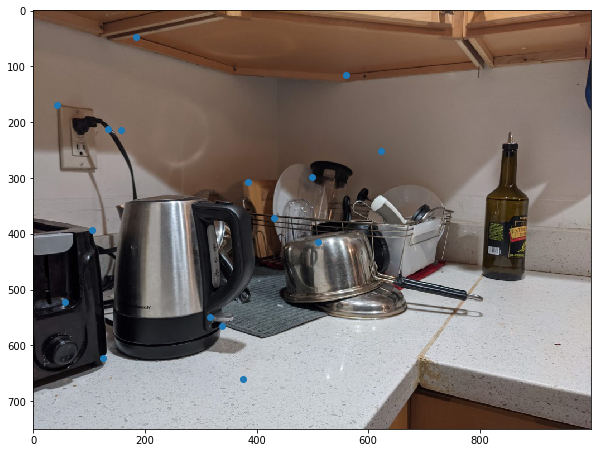

In [81]:
# Visualize matched points
print(len(feat_map))
matched_pts1 = list(feat_map.keys())
matched_pts2 = np.array([feat_map[p] for p in matched_pts1])
matched_pts1 = np.array(matched_pts1)

# matched_pts1[:, [0, 1]] = matched_pts1[:, [1, 0]]
# matched_pts2[:, [0, 1]] = matched_pts2[:, [1, 0]]

plt.figure(figsize=[10,10])
plt.imshow(img1)
#plt.scatter(x=matched_pts1[:,1], y=matched_pts1[:,0])# This works
plt.scatter(x=matched_pts1[:,0], y=matched_pts1[:,1])# THis is ideal
#plt.savefig(f'outputs/{img_name}_harris1.jpg', bbox_inches='tight')

plt.figure(figsize=[10,10])
plt.imshow(img2)
#plt.scatter(x=matched_pts2[:,1], y=matched_pts2[:,0])
plt.scatter(x=matched_pts2[:,0], y=matched_pts2[:,1])# THis is ideal

In [83]:
#def ransac(feat_map, num_iters = 100):
num_iters = 1000
num_pts = 10
distances = []
for i in range(num_iters):
    ransac_pts1 = random.sample(list(feat_map.keys()), num_pts)
    ransac_pts2 = np.array([feat_map[p] for p in ransac_pts1])
    ransac_pts1 = np.array(ransac_pts1)
    H = compute_homography(ransac_pts1, ransac_pts2)
    inliers = 0
    best_config = {'inliers': 0, 'H': None}
    for key in feat_map:
        p = np.array([[key[1]], [key[0]], [1]])
        new_p = np.array([[feat_map[key][1]],
                         [feat_map[key][0]],
                         [1]])
        new_p = np.matmul(H, new_p)
        new_p = new_p / new_p[2]

        p = p[:2].flatten().reshape(1, 2)
        new_p = np.array(new_p[:2].flatten()).reshape(1, 2).astype(np.int)

        distance = np.linalg.norm(new_p-p)
        distances.append(distance)
        #print(distance)
        if int(distance) < 500:
            inliers += 1
            #print("INNIE")
    if inliers > best_config['inliers']:
        best_config = {'inliers': inliers, 'H': H}

/mnt/d/wsl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


In [84]:
print(best_config)
min(distances)

{'inliers': 10, 'H': array([[ 5.53021886e-01, -9.49499905e-02,  4.00256081e+02],
       [-1.22975636e-01,  8.18654463e-01,  3.75475004e+01],
       [-3.99669191e-04, -4.80843561e-05,  1.00000000e+00]])}


25.553864678361276

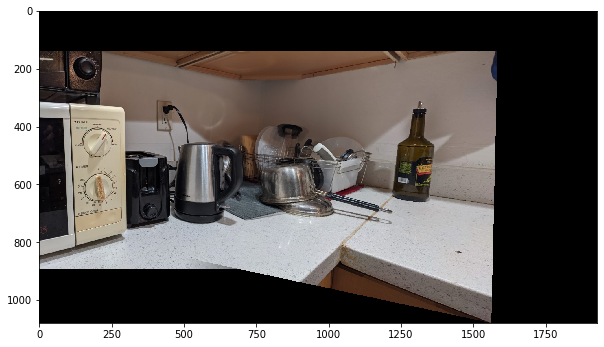

In [85]:
H=best_config['H']
mos = mosaic(img1, img2, H)
plt.figure(figsize=[10,10])
plt.imshow(mos)

In [11]:
from scipy.signal import convolve2d
def gaussian_kernel(size, sigma):
    kernel = cv2.getGaussianKernel(size, sigma)
    return np.outer(kernel, np.transpose(kernel))

def SSD(A, B):
    return np.sum(np.sum((A-B)**2))

def get_feature_patches(patches):
    gauss_kernel = gaussian_kernel(33, 3)
    blurred_patches = []
    for patch in patches:
        if False:    # Color
            blurred_patch = convolve2d(patch[1][:, :, 0], gauss_kernel, mode="valid", boundary="wrap")
        else: # Gray
            blurred_patch = convolve2d(patch[1], gauss_kernel, mode="valid", boundary="wrap")
        blurred_patch = (blurred_patch - np.mean(blurred_patch))/np.std(blurred_patch)  # Normalize the patch
        blurred_patches.append((patch[0], blurred_patch))
    return blurred_patches

def compute_map_features(feat1, feat2):
    feature_map = {}
    for i in range(len(feat1)):
        corner_NNs = []
        for j in range(len(feat2)):
            corner_NNs.append((feat2[j][0], SSD(feat1[i][1], feat2[j][1])))
        corner_NNs.sort(key = lambda x: x[1])
        thresh = corner_NNs[0][1] / corner_NNs[1][1]
        if thresh < 0.2:
            feature_map[tuple(feat1[i][0])] = corner_NNs[0][0]
    return feature_map

def compute_features(self, plot_feat):
    patches1 = self.__get_patches__(self.image1, self.points1)
    patches2 = self.__get_patches__(self.image2, self.points2)
    feat1 = self.__get_feature_patches__(patches1)
    feat2 = self.__get_feature_patches__(patches2)
    self.feature_map = self.__compute_map_features__(feat1, feat2)
    if plot_feat:
        keys = np.array(list(self.feature_map.keys()))
        plt.imshow(self.image1)
        plt.scatter(keys[:, 1], keys[:, 0],
                    marker="x", color="red", s=200)
        plt.show()
        for key in self.feature_map:
            plt.imshow(self.image2)
            plt.scatter(self.feature_map[key][1], self.feature_map[key][0],
                        marker="x", color="red", s=200)
            plt.show()
    assert(len(self.feature_map) >= 4)